In [1]:
import numpy as np
from numpy import sqrt, pi
import matplotlib.pyplot as plt

from numpy import cos, sin

from matplotlib.colors import Normalize
from matplotlib import cm

# Part 0 :: Define Objects

## Implement `ConductingCylinderOnGrid`

In [2]:
from numbers import Integral
from numpy import pi, cos, sin
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

class ConductingCylinderOnGrid(object):
    
    def __init__(self, rho_arr, z_arr, R_ind, zd_ind, zu_ind, V0):
        
        ## Check arguments and set them members
        for _arg in (rho_arr, z_arr):
            assert isinstance(_arg, np.ndarray)
            assert _arg.ndim == 1
            assert np.diff(_arg).std() < 1e-15
        assert rho_arr[0] == 0
        for _arg in (R_ind, zd_ind, zu_ind): 
            assert isinstance(_arg, Integral)
        for z_ind in (zd_ind, zu_ind): 
            assert z_ind in range(-z_arr.size, z_arr.size)
        assert R_ind in range(-rho_arr.size, rho_arr.size)
        
        self.rho_arr, self.z_arr = rho_arr, z_arr
        self.drho, self.dz = rho_arr[1]-rho_arr[0], z_arr[1]-z_arr[0]
        self.R_ind, self.zd_ind, self.zu_ind = R_ind, zd_ind, zu_ind
        self.R = self.rho_arr[R_ind]
        self.zd, self.zu = self.z_arr[[zd_ind, zu_ind]]
        self.V0 = V0
        
        ## Construct surface points indice
        self.s1_ind = [(rho_ind, self.zu_ind) 
                       for rho_ind in range(self.R_ind+1)]
        self.s2_ind = [(self.R_ind, z_ind) 
                       for z_ind in range(self.zd_ind,self.zu_ind+1)]
        self.s3_ind = [(rho_ind, self.zd_ind) 
                       for rho_ind in range(self.R_ind+1)]    
        
        ## Construct surface coordinate arrays
        self.s1_rho_arr = self.rho_arr[np.array(self.s1_ind)[:,0]]
        self.s2_z_arr = self.z_arr[np.array(self.s2_ind)[:,1]]
        self.s3_rho_arr = self.rho_arr[np.array(self.s3_ind)[:,0]]
        
        ## Construct a mask
        _Rho, _Z = np.meshgrid(self.rho_arr, self.z_arr, indexing='ij')
        self.mask = (_Rho<=self.R) & (self.zd<=_Z) & (_Z<=self.zu)
        
        
    def eval_surf_charge_density(self, V):
        """Evaluate charge density in atomic unit"""
        assert isinstance(V, np.ndarray)
        assert V.shape == (self.rho_arr.size, self.z_arr.size)
        _epsil0 = 1.0 / (4*pi)
        _s1_sigma = np.array(
            [_epsil0 * -(V[rho_ind,z_ind+1]-V[rho_ind,z_ind]) / self.dz 
             for (rho_ind, z_ind) in self.s1_ind])
        _s2_sigma = np.array(
            [_epsil0 * -(V[rho_ind+1,z_ind]-V[rho_ind,z_ind]) / self.drho 
             for (rho_ind, z_ind) in self.s2_ind])
        _s3_sigma = np.array(
            [_epsil0 * (V[rho_ind,z_ind]-V[rho_ind,z_ind-1]) / self.dz 
             for (rho_ind, z_ind) in self.s3_ind])
        return _s1_sigma, _s2_sigma, _s3_sigma
    
    
    def get_total_charge(self, V):
        
        _s1_sigma,_s2_sigma,_s3_sigma = self.eval_surf_charge_density(V)
        
        _s1_rho_mul_sigma = self.s1_rho_arr * _s1_sigma
        _Q_s1 = 2*pi*np.sum(
            0.5 * (_s1_rho_mul_sigma[:-1] + _s1_rho_mul_sigma[1:])
            * np.diff(self.s1_rho_arr))

        _s3_rho_mul_sigma = self.s3_rho_arr * _s3_sigma
        _Q_s3 = 2*pi*np.sum(
            0.5 * (_s3_rho_mul_sigma[:-1] + _s3_rho_mul_sigma[1:]) 
            * np.diff(self.s3_rho_arr))

        _Q_s2 = 2*pi*self.R * np.sum(
            0.5 * (_s2_sigma[:-1] + _s2_sigma[1:]) 
            * np.diff(self.s2_z_arr))

        _Q_total = _Q_s1 + _Q_s2 + _Q_s3
        return _Q_total

    
    def show_charge_density_3D(self, V, ax, nphi=51):
        
        assert isinstance(ax3, Axes3D)
        
        _s1_sigma,_s2_sigma,_s3_sigma = self.eval_surf_charge_density(V)

        _sigma = np.array([*_s1_sigma, *_s2_sigma, *_s3_sigma])
        _ch_max, _ch_min = _sigma.max(), _sigma.min()
        _vmin, _vmax = _ch_min, _ch_max
        _norm = Normalize(_vmin, _vmax, clip=True)
        _ch_cm = cm.jet
        
        ## Construct 3D mesh 
        _phi_arr = np.linspace(0, 2*pi, nphi)
        
        # for Surface 1 (upper disk)
        _s1_3d_rho_grid = np.empty((self.s1_rho_arr.size+1,))
        _s1_3d_rho_grid[1:-1]=0.5*(self.s1_rho_arr[:-1]+self.s1_rho_arr[1:])
        _s1_3d_rho_grid[0] = 0.0
        _s1_3d_rho_grid[-1] = self.R
        
        _S1_3D_Rho_Grid,_S1_3D_Phi_Grid=np.meshgrid(_s1_3d_rho_grid,_phi_arr)
        _S1_3D_X = _S1_3D_Rho_Grid * cos(_S1_3D_Phi_Grid)
        _S1_3D_Y = _S1_3D_Rho_Grid * sin(_S1_3D_Phi_Grid)
        _S1_3D_Z = np.full_like(_S1_3D_X, self.zu)

        _S1_Colors = np.empty((_phi_arr.size, self.s1_rho_arr.size))
        _S1_Colors[:] = _s1_sigma
        _S1_C = _ch_cm(_norm(_S1_Colors))

        # for Surface 3 (lower disk)
        _s3_3d_rho_grid = _s1_3d_rho_grid
        _S3_3D_Rho_Grid,_S3_3D_Phi_Grid=np.meshgrid(_s3_3d_rho_grid,_phi_arr)
        _S3_3D_X = _S3_3D_Rho_Grid * cos(_S3_3D_Phi_Grid)
        _S3_3D_Y = _S3_3D_Rho_Grid * sin(_S3_3D_Phi_Grid)
        _S3_3D_Z = np.full_like(_S3_3D_X, self.zd)

        _S3_Colors = np.empty((_phi_arr.size, self.s3_rho_arr.size))
        _S3_Colors[:] = _s3_sigma
        _S3_C = _ch_cm(_norm(_S3_Colors))
        
        # for Surface 2 (middle cylinder)
        _s2_3d_z_grid = np.empty(self.s2_z_arr.size + 1,)
        _s2_3d_z_grid[0] = self.s2_z_arr[0]
        _s2_3d_z_grid[1:-1]=0.5*(self.s2_z_arr[:-1]+self.s2_z_arr[1:])
        _s2_3d_z_grid[-1] = self.s2_z_arr[-1]

        _S2_3D_Z_Grid,_S2_3D_Phi_Grid=np.meshgrid(_s2_3d_z_grid,_phi_arr)
        _S2_3D_X = self.R * cos(_S2_3D_Phi_Grid)
        _S2_3D_Y = self.R * sin(_S2_3D_Phi_Grid)
        _S2_3D_Z = _S2_3D_Z_Grid

        _S2_Colors = np.empty((_phi_arr.size, self.s2_z_arr.size))
        _S2_Colors[:] = _s2_sigma
        _S2_C = _ch_cm(_norm(_S2_Colors))

        _ax3 = ax

        # This order matters
        _ax3.plot_surface(_S2_3D_X, _S2_3D_Y, _S2_3D_Z, 
                          facecolors=_S2_C, cmap=_ch_cm)
        _ax3.plot_surface(_S1_3D_X, _S1_3D_Y, _S1_3D_Z, 
                          facecolors=_S1_C, cmap=_ch_cm)
        _ax3.plot_surface(_S3_3D_X, _S3_3D_Y, _S3_3D_Z, 
                          facecolors=_S3_C, cmap=_ch_cm)

        _ax3.view_init(elev=30, azim=None)

        _ax3.set_axis_off()

## Implement `ElectricPotentialAtCylindricalCoord`

In [3]:
import numpy as np

class ElectricPotentialAtCylindricalCoord(object):
    
    _max_iter_num = 50000
    
    def __init__(self, rho_arr, z_arr, bd_cond):
        
        ## Check arguments and set as members
        for _arg in (rho_arr, z_arr): 
            assert isinstance(_arg, np.ndarray) and _arg.ndim == 1
        assert np.diff(rho_arr).std()<1e-15 and np.diff(z_arr).std()<1e-15
        self.rho_arr, self.z_arr = rho_arr, z_arr
        self.drho, self.dz = rho_arr[1] - rho_arr[0], z_arr[1] - z_arr[0]
        
        assert isinstance(bd_cond,np.ma.MaskedArray)
        assert bd_cond.shape == (rho_arr.size, z_arr.size)
        self.bd_cond = bd_cond
        
        ## Allocate and Initialize the potential array
        self.V = np.empty(self.bd_cond.shape, dtype=float)
        self.V[:] = np.random.rand(*self.bd_cond.shape)
        self.V[~self.bd_cond.mask] = self.bd_cond[~self.bd_cond.mask]
        
        
    def go_to_solution(self, stop_thres=1e-3):
        
        _c1 = 1.0 / (4.0/self.drho**2 + 2.0/self.dz**2)
        _c2 = 1.0 / (2.0/self.drho**2 + 2.0/self.dz**2)        
        _converged = False
        
        for _ in range(self._max_iter_num):
            
            _V_prev = self.V.copy()

            self.V[0,1:-1] = _c1 * (
                4.0 / self.drho**2 * self.V[1,1:-1]
                + 1.0 / self.dz**2 * (self.V[0,2:] + self.V[0,:-2])
            )
            self.V[1:-1,1:-1] = _c2 * (
                1.0/self.drho**2 * (self.V[2:,1:-1] + self.V[:-2,1:-1]) 
                + (1.0/2.0/self.drho/self.rho_arr[1:-1]
                   *(self.V[2:,1:-1]-self.V[:-2,1:-1]).transpose()).transpose()
                + 1.0/self.dz**2 * (self.V[1:-1,2:] + self.V[1:-1,:-2])
            )

            self.V[~self.bd_cond.mask] = self.bd_cond[~self.bd_cond.mask]
            
            if np.all(np.abs(self.V - _V_prev) < stop_thres): 
                _converged = True
                break
        
        if not _converged: 
            raise Exception("Failed to find converged potential")
            
    def __getitem__(self, index_exp):
        return self.V[index_exp]

## Implement `AzimSymmCylinderSystem`

In [4]:
from numbers import Real

class AzimSymmCylinderSystem(object):
    def __init__(self, rho_min, rho_max, min_delta_rho, 
                 z_min, z_max, min_delta_z, V_box_boundary=0.0):
        
        assert (rho_min >= 0) and (rho_min < rho_max)
        assert (z_min < z_max)

        def get_N_grid(xmin, xmax, min_delta_x):
            return int((xmax-xmin+min_delta_x)/min_delta_x) + 1
        
        assert isinstance(V_box_boundary, Real)
        self.V_box_boundary = V_box_boundary

        N_rho = get_N_grid(rho_min, rho_max, min_delta_rho)
        self.rho_arr = np.linspace(rho_min, rho_max, N_rho)
        self.delta_rho = self.rho_arr[1] - self.rho_arr[0]
        self.rho_min, self.rho_max = rho_min, rho_max
        self.diameter = 2.0 * rho_max

        N_z = get_N_grid(z_min, z_max, min_delta_z)
        self.z_arr = np.linspace(z_min, z_max, N_z)
        self.delta_z = self.z_arr[1] - self.z_arr[0]
        self.z_min, self.z_max = z_min, z_max
        self.height = z_max - z_min
        
        self.extent = (rho_min, rho_max, z_min, z_max)

        self.grid_shape = (N_rho, N_z)
        
        ## Boundary condition
        # Construct a boundary condition array
        _bd_cond = np.ma.array(
            np.full(self.grid_shape, -1e10, dtype=float), mask=True)
        self.V = ElectricPotentialAtCylindricalCoord(
            self.rho_arr, self.z_arr, _bd_cond)
        
        # Initialize the boundary condition on potential
        assert isinstance(self.V.bd_cond, np.ma.MaskedArray)
        self.init_bd_cond()
        
        ## Cylinders!
        self.cyliners = []
        
        
    def init_bd_cond(self):
        
        self.V.bd_cond.mask[:,:] = True
        
        self.V.bd_cond.mask[:,[0,-1]] = False
        self.V.bd_cond[:,[0,-1]] = self.V_box_boundary
        
        self.V.bd_cond.mask[-1,:] = False
        self.V.bd_cond[-1,:] = self.V_box_boundary

        if self.rho_arr[0] > 0: 
            self.V.bd_cond.mask[0,:] = False
            self.V.bd_cond[0,:] = self.V_box_boundary
    
    
    def remove_all_cylinders(self):
        self.cyliners.clear()
        self.init_bd_cond()
    
    
    def add_cylinder(self, R_ind, zd_ind, zu_ind, V0):
        
        ## Construct and register a new Cylinder object
        _cylin = ConductingCylinderOnGrid(
            self.rho_arr, self.z_arr, R_ind, zd_ind, zu_ind, V0)
        self.cyliners.append(_cylin)
        
        ## Update the boundary condition
        self.V.bd_cond.mask[_cylin.mask] = False
        self.V.bd_cond[_cylin.mask] = _cylin.V0
        
        
    def get_charge_of_each_cylinder(self):
        return np.array([cylin.get_total_charge(self.V.V) 
                         for cylin in self.cyliners])

# Part I :: Electric Potential for Cylinders in a Cylinder

## Construct a system of two cylinders in a cylinder

In [5]:
sys = AzimSymmCylinderSystem(
    rho_min=0.0, rho_max=5.0, min_delta_rho=0.05, 
    z_min=-3.0, z_max=6.0, min_delta_z=0.1
)

sys.add_cylinder(R_ind=33, zd_ind=10, zu_ind=10+10, V0=3.0)
sys.add_cylinder(R_ind=53, zd_ind=50, zu_ind=60, V0=-2.0)

## Find solution for laplace equation to obtain the potential $V$

In [6]:
sys.V.go_to_solution(stop_thres=1e-5)

## Calculate charge on each cylinder

In [7]:
sys.get_charge_of_each_cylinder()

array([ 7.6822729 , -7.76794341])

## Plot the potential

Text(0, 0.5, 'z / a.u.')

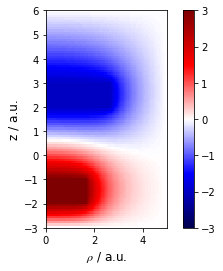

In [8]:
fig, ax = plt.subplots()
vmax = np.abs(sys.V.V).max()
vmin = -vmax
img = ax.imshow(sys.V.V.transpose(), origin='lower', extent=sys.extent,
                cmap='seismic', vmin=vmin, vmax=vmax)
cb = fig.colorbar(img, ax=ax)
ax.set_xlabel(r"$\rho$ / a.u.")
ax.set_ylabel(r"z / a.u.")

# Part II :: Capacitance Depending on the Distance

## Evaluation

In [9]:
sys = AzimSymmCylinderSystem(
    rho_min=0.0, rho_max=5.0, min_delta_rho=0.05, 
    z_min=-3.0, z_max=6.0, min_delta_z=0.1
)

perp = np.linspace(0.1, 0.9, 11)
zd_ind_arr = (sys.z_arr.size * perp).astype(int) - 5

V0 = 2.0
deltaV = abs(sys.V_box_boundary - V0)
Qtot_list, capaci_list = [], []
for zd_ind in zd_ind_arr:
    
    sys.remove_all_cylinders()
    sys.add_cylinder(R_ind=33, zd_ind=zd_ind, zu_ind=zd_ind+10, V0=V0)

    sys.V.go_to_solution(stop_thres=1e-5)
    
    cylin, = sys.cyliners
    Qtot = cylin.get_total_charge(sys.V.V)
    capaci = Qtot / deltaV
    
    Qtot_list.append(Qtot)
    capaci_list.append(capaci)

## Data Visualization : capacitance for each geometry setting

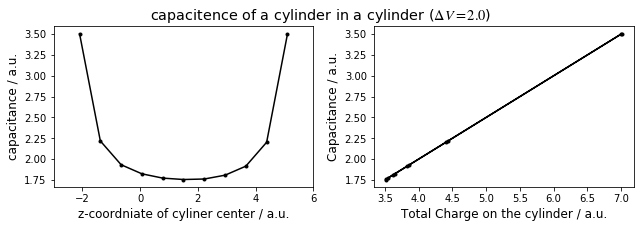

In [10]:
figcc, (axcc, axqc) = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

cylin_h = sys.cyliners[0].zu - sys.cyliners[0].zd
z_perp = sys.z_min + perp * sys.height
axcc.plot(z_perp, capaci_list, '.-', color='black')
axcc.set_xlim(sys.z_arr[0], sys.z_arr[-1])
axcc.set_ylabel("capacitance / a.u.")
axcc.set_xlabel("z-coordniate of cyliner center / a.u.")

axqc.plot(Qtot_list, capaci_list, '.-k')
axqc.set_xlabel("Total Charge on the cylinder / a.u.")
axqc.set_ylabel("Capacitance / a.u.")

figcc.suptitle(
    "capacitence of a cylinder in a cylinder ($\Delta{{V}}={}$)".format(deltaV), 
               va='baseline', fontsize='x-large')

figcc.tight_layout()
figcc.savefig("capacitance-of-a-cylinder-in-a-cylinder.png")

# Part III :: Demonstration - "Capacitance is a purely Geometric Quantity"

## Evaluation

In [11]:
sys = AzimSymmCylinderSystem(
    rho_min=0.0, rho_max=5.0, min_delta_rho=0.05, 
    z_min=-3.0, z_max=6.0, min_delta_z=0.1
)

V0_arr = np.linspace(0.1, 10.0, 15)

Qtot_list, capaci_list, deltaV_list = [], [], []
for V0 in V0_arr:
    
    sys.remove_all_cylinders()
    sys.add_cylinder(R_ind=33, zd_ind=30, zu_ind=30+10, V0=V0)
    
    sys.V.go_to_solution(stop_thres=1e-5)
    
    cylin, = sys.cyliners
    Qtot = cylin.get_total_charge(sys.V.V)
    deltaV = abs(sys.V_box_boundary - cylin.V0)
    capaci = Qtot / deltaV
    
    Qtot_list.append(Qtot)
    capaci_list.append(capaci)
    deltaV_list.append(deltaV)

## Data Visualization : Capacitence with fixed geometry and varying voltage

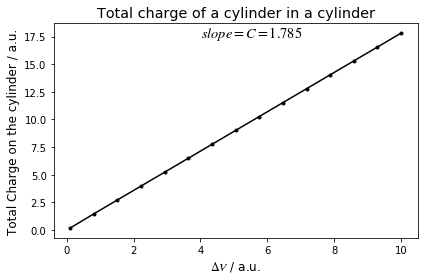

In [12]:
figc, axc = plt.subplots()
axc.plot(deltaV_list, Qtot_list, '.-k')
axc.set_xlabel(r"$\Delta{V}$ / a.u.")
axc.set_ylabel("Total Charge on the cylinder / a.u.")
axc.set_title("Total charge of a cylinder in a cylinder")

capa_av = np.average(capaci_list)
axc.text(0.0,0.95,r"$slope=C={:.3f}$".format(capa_av), 
         fontsize='x-large', transform=ax.transAxes)

figc.tight_layout()
figc.savefig("total-charge-of-cylinder-in-cylinder-varying-deltaV.png")

# Part IV :: Surface Charge Density $\sigma$ of a cylinder

## Potential Evaluation

In [13]:
sys = AzimSymmCylinderSystem(
    rho_min=0.0, rho_max=5.0, min_delta_rho=0.05, 
    z_min=-3.0, z_max=6.0, min_delta_z=0.1
)

sys.add_cylinder(R_ind=33, zd_ind=40, zu_ind=40+30, V0=3.0)

sys.V.go_to_solution(stop_thres=1e-5)

## Visualizing charge distribution

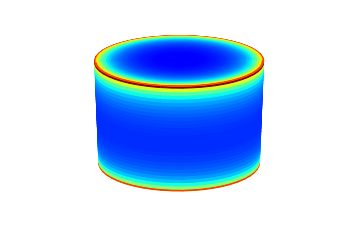

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig3, ax3 = plt.subplots(subplot_kw={'projection':'3d'})

cylin, = sys.cyliners
cylin.show_charge_density_3D(sys.V.V, ax3)

fig3.savefig("charge-density-of-single-cylinder.png")